In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = 12, 8

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2023-02-22 11:17:13.112511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 11:17:14.129158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
2023-02-22 11:17:14.129233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
20

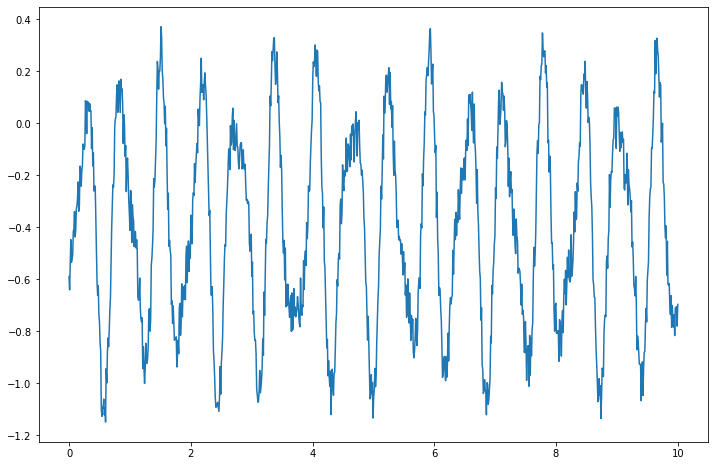

1000


In [2]:
def generate_data(x_min, x_max, n_datapoints=300, f1 = 10, f2=20, offset1 = 0, offset2=0.2, noise=0.1):
    x = np.linspace(x_min, x_max, n_datapoints)
    y = 0.5*np.sin(f1*(x-offset1))+0.2*np.sin(f2*(x-offset2))+noise*np.random.rand(n_datapoints)-0.5
    return x,y

x,y = generate_data(x_min=0.0, x_max=10.0, n_datapoints=1000, f1=10, f2=17, offset1=0.1, offset2=0.3, noise=0.2)

plt.plot(x,y)
plt.show()
print(len(y))

In [3]:
#use 50 points for the window width
sequence_length = 50 
sequence = []
for index in range(len(y) - sequence_length):
    sequence.append(y[index: index + sequence_length +1])

sequence = np.array(sequence)

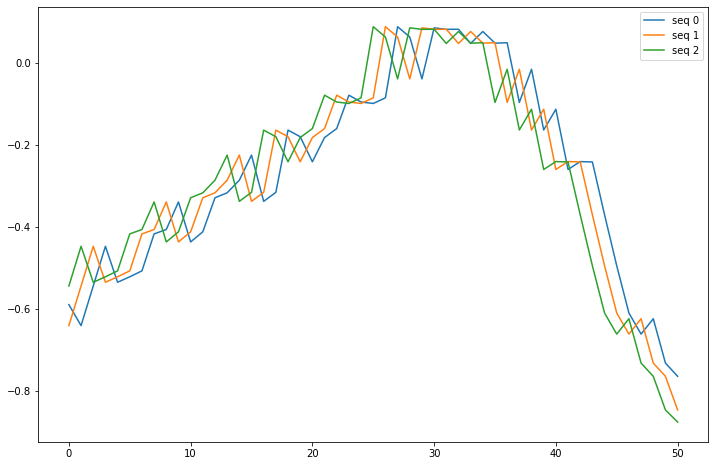

In [4]:
#
# Look at a few examples of the training sequences
#

plt.plot(sequence[0], label='seq 0')
plt.plot(sequence[1], label='seq 1')
plt.plot(sequence[2], label='seq 2')

#one towards the end
#seq_no = len(sequence)-int(len(sequence)/10.0)
#plt.plot(sequence[seq_no], label='seq '+ str(seq_no))

plt.legend()
plt.show()


In [5]:
#use 80% for training, 20% for testing
train_index = round(0.8 * len(sequence))
print('The training data will run up to index {}'.format(train_index))

train = sequence[:int(train_index), :]
x_train = train[:, :-1]
y_train = train[:, -1]
x_test  = sequence[int(train_index):, :-1]
y_test  = sequence[int(train_index):, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

print(x_train.shape)


The training data will run up to index 760
(760, 50, 1)


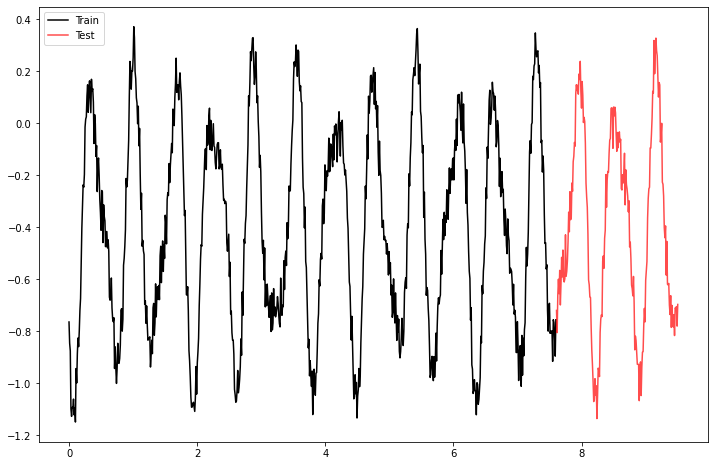

In [6]:
plt.plot(x[:train_index], y_train, label='Train', color='black',)
plt.plot(x[train_index:-sequence_length], y_test,  label='Test',  color='red', alpha=0.7)

plt.legend()
plt.show()

In [7]:
class Brain(tf.keras.Model):
    def __init__(self):
        super(Brain, self).__init__()
        self.lstm1 = tf.keras.layers.LSTM(units=64, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(units=32, return_sequences=False)
        self.dense = tf.keras.layers.Dense(1, activation=None)
    
    def call(self, x, training):
        x = self.lstm1(x)
        x = self.lstm2(x)
        return self.dense(x)
    
    def summary(self, shape):
        x = tf.keras.Input(shape)
        model = tf.keras.Model(inputs=x, outputs=self.call(x, training=False))
        model.summary(line_length=80)

# Create an instance of the model
model = Brain()
model.summary((50, 1))

2023-02-22 11:17:15.647614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-22 11:17:15.647654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: francesco-15IMH05
2023-02-22 11:17:15.647664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: francesco-15IMH05
2023-02-22 11:17:15.647778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-22 11:17:15.647811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-02-22 11:17:15.647820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-02-22 11:17:15.648311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is o

Model: "model"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 50, 1)]                 0           
                                                                                
 lstm (LSTM)                        (None, 50, 64)                  16896       
                                                                                
 lstm_1 (LSTM)                      (None, 32)                      12416       
                                                                                
 dense (Dense)                      (None, 1)                       33          
                                                                                
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
________________________________________________________________________________


In [8]:
# Loss and optimizer
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

# Monitoring metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')


In [9]:
@tf.function
def train_step(X, Y):
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        loss = loss_object(Y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)

    
@tf.function
def test_step(X, Y):
    predictions = model(X, training=False)
    t_loss = loss_object(Y, predictions)
    
    test_loss(t_loss)


In [10]:
EPOCHS = 50
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()
    
    for i in range(0, len(x_train), BATCH_SIZE):
        train_step(x_train[i:i+BATCH_SIZE], y_train[i:i+BATCH_SIZE])
    
    for i in range(0, len(x_test), BATCH_SIZE):
        test_step(x_test, y_test)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {round(train_loss.result().numpy(), 4)}, '
        f'Test Loss: {round(test_loss.result().numpy(), 4)}, '
    )


Epoch 1, Loss: 0.18279999494552612, Test Loss: 0.10360000282526016, 
Epoch 2, Loss: 0.07729999721050262, Test Loss: 0.06120000034570694, 
Epoch 3, Loss: 0.06129999831318855, Test Loss: 0.061799999326467514, 
Epoch 4, Loss: 0.06239999830722809, Test Loss: 0.058800000697374344, 
Epoch 5, Loss: 0.06589999794960022, Test Loss: 0.06960000097751617, 
Epoch 6, Loss: 0.06509999930858612, Test Loss: 0.05730000138282776, 
Epoch 7, Loss: 0.05829999968409538, Test Loss: 0.0560000017285347, 
Epoch 8, Loss: 0.061799999326467514, Test Loss: 0.0568000003695488, 
Epoch 9, Loss: 0.06310000270605087, Test Loss: 0.056299999356269836, 
Epoch 10, Loss: 0.05950000137090683, Test Loss: 0.05480000004172325, 
Epoch 11, Loss: 0.05779999867081642, Test Loss: 0.05299999937415123, 
Epoch 12, Loss: 0.05849999934434891, Test Loss: 0.05460000038146973, 
Epoch 13, Loss: 0.05979999899864197, Test Loss: 0.054099999368190765, 
Epoch 14, Loss: 0.0608999989926815, Test Loss: 0.05590000003576279, 
Epoch 15, Loss: 0.057500001